# Kitchenware Classification Competition

Classify kitchen items into 6 categories: cups, glasses, plates, spoons, forks and knives

Follow this [link](https://www.kaggle.com/competitions/kitchenware-classification/overview)

## Dataset acquisition

Downlading data from the kaggle using the kaggle api

In [48]:
%env KAGGLE_USERNAME=username

env: KAGGLE_USERNAME=username


In [49]:
%env KAGGLE_KEY=xxxxxxxxxxxxxxxxxxxxxxxx

env: KAGGLE_KEY=xxxxxxxxxxxxxxxxxxxxxxxx


In [4]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 12.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=149b37f1c5931dbd7b30080784bd9b18124d8daa41d62f0791d79bce933fbcdd
  Stored in directory: /home/jovyan/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [5]:
!kaggle competitions download -c kitchenware-classification

100%|█████████████████████████████████████▊| 1.38G/1.39G [00:22<00:00, 93.1MB/s]
100%|██████████████████████████████████████| 1.39G/1.39G [00:22<00:00, 67.2MB/s]


In [13]:
!ls -lh

total 1.4G
drwxr-sr-x 3 jovyan jovyan 4.0K Nov 25 17:04 kitchenware-classification
-rw-r--r-- 1 jovyan jovyan 6.6K Nov 25 17:04 Kitchenware-Classification-Competition.ipynb
-rw-r--r-- 1 jovyan jovyan 1.4G Nov 25 16:59 kitchenware-classification.zip
-rw-r--r-- 1 jovyan jovyan  525 Nov 25 16:52 README.md
-rw-r--r-- 1 jovyan jovyan 6.5K Nov 25 16:52 single-gpu-tensorflow.ipynb


In [8]:
# !unzip kitchenware-classification.zip

## Dataset Description
This dataset contains images of different kitchenware

### Files
- **train.csv** - the training set (Image IDs and classes)
- **test.csv** - the test set (Just image IDs)
- **sample_submission.csv** - a sample submission file in the correct format
- **images/** - the images in the JPEG format


In [3]:
import os
import pandas as pd
import shutil
from pathlib import Path
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

2022-11-26 09:47:27.500635: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
train_df = pd.read_csv("./kitchenware-classification/train.csv")
train_df.head()

,Id,label
0,2441,glass
1,0,cup
2,2442,glass
3,6535,spoon
4,4814,plate


In [5]:
train_df["image"] = train_df["Id"].map(lambda x: f"{x:0>4}.jpg")

In [4]:
train_df.head()

,Id,label,image
0,2441,glass,2441.jpg
1,0,cup,0000.jpg
2,2442,glass,2442.jpg
3,6535,spoon,6535.jpg
4,4814,plate,4814.jpg


In [6]:
test_df = pd.read_csv("./kitchenware-classification/test.csv")
test_df.head()

,Id
0,6534
1,3504
2,1649
3,4815
4,1651


In [7]:
train_df.shape, test_df.shape

((5559, 3), (2362, 1))

In [8]:
sample_submission = pd.read_csv("./kitchenware-classification/sample_submission.csv")
sample_submission.head()

,Id,label
0,6534,knife
1,3504,cup
2,1649,plate
3,4815,knife
4,1651,knife


In [9]:
sample_submission.shape

(2362, 2)

In [11]:
labels = list(train_df["label"].unique())
labels

['glass', 'cup', 'spoon', 'plate', 'knife', 'fork']

### Decide where you want to store the images with the different  labels for training and validation datasets

In [27]:
path = "./kitchenware-classification/images/"
for label in labels:
    label_path = f"{path}{label}"
    print(label_path)
    Path(label_path).mkdir(parents=True, exist_ok=True)

./kitchenware-classification/images/glass
./kitchenware-classification/images/cup
./kitchenware-classification/images/spoon
./kitchenware-classification/images/plate
./kitchenware-classification/images/knife
./kitchenware-classification/images/fork


In [31]:
dirs = [ name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name)) ]
dirs

['cup', 'knife', 'spoon', 'fork', 'plate', 'glass']

In [12]:
path = "./kitchenware-classification/project_images/"

In [35]:

for label in labels:
    label_imgs = list(train_df[train_df["label"]==label]["image"])
    for img in label_imgs:
        src_path = f"{path}{img}"
        dest_path = f"{path}{label}/{img}"
        temp = shutil.move(src_path, dest_path)

In [65]:
total_files = 0
for dir_ in dirs:
    total_files += len(os.listdir(f"{path}{dir_}"))
total_files

5559

In [13]:
!ls -lh ./kitchenware-classification/project_images/

total 160K
drwxr-sr-x 2 jovyan jovyan 36K Nov 25 19:45 cup
drwxr-sr-x 2 jovyan jovyan 20K Nov 25 19:45 fork
drwxr-sr-x 2 jovyan jovyan 20K Nov 25 19:45 glass
drwxr-sr-x 2 jovyan jovyan 24K Nov 25 19:45 knife
drwxr-sr-x 2 jovyan jovyan 36K Nov 25 19:45 plate
drwxr-sr-x 2 jovyan jovyan 24K Nov 25 19:45 spoon


### Data pre-processing and generating datasets (for training and validation)

In [13]:
image_size = (290, 290)
batch_size = 32
dataset_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

In [14]:
train_ds = dataset_gen.flow_from_directory(
    path,
    target_size=image_size,
    batch_size=batch_size,
    subset="training"
)

Found 4450 images belonging to 6 classes.


In [15]:
val_ds = dataset_gen.flow_from_directory(
    path,
    target_size=image_size,
    batch_size=batch_size,
    subset="validation"
)

Found 1109 images belonging to 6 classes.


In [16]:
train_ds.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [15]:
train_ds.classes

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

### Model building and training the model

In [17]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [18]:
input_size = 299
learning_rate = 0.001
size = 100
droprate = 0.2

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [19]:
model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint, early_stop])

2022-11-26 09:48:38.701472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 09:48:38.708575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 09:48:38.709189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 09:48:38.710647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/50


2022-11-26 09:48:45.188289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-26 09:48:45.833269: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-26 09:48:45.834243: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-26 09:48:45.834280: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-26 09:48:45.835345: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-26 09:48:45.835441: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


140/140 [==============================] - 82s 547ms/step - loss: 0.2816 - accuracy: 0.9067 - val_loss: 0.1594 - val_accuracy: 0.9522
Epoch 2/50
140/140 [==============================] - 68s 482ms/step - loss: 0.1419 - accuracy: 0.9528 - val_loss: 0.1657 - val_accuracy: 0.9450
Epoch 3/50
140/140 [==============================] - 69s 489ms/step - loss: 0.1144 - accuracy: 0.9622 - val_loss: 0.1305 - val_accuracy: 0.9540
Epoch 4/50
140/140 [==============================] - 68s 485ms/step - loss: 0.0893 - accuracy: 0.9712 - val_loss: 0.1416 - val_accuracy: 0.9558
Epoch 5/50
140/140 [==============================] - 68s 482ms/step - loss: 0.0785 - accuracy: 0.9748 - val_loss: 0.1553 - val_accuracy: 0.9513
Epoch 6/50
140/140 [==============================] - 67s 481ms/step - loss: 0.0658 - accuracy: 0.9789 - val_loss: 0.1477 - val_accuracy: 0.9513
Epoch 7/50
140/140 [==============================] - 68s 483ms/step - loss: 0.0563 - accuracy: 0.9820 - val_loss: 0.1460 - val_accuracy: 0.9

### Predict on test set 

In [20]:
test_df.head()

,Id
0,6534
1,3504
2,1649
3,4815
4,1651


In [21]:
path = "./kitchenware-classification/images/"
test_df['image'] = test_df['Id'].map(lambda x: f'{path}{x:0>4}.jpg')
test_df.head()

,Id,image
0,6534,./kitchenware-classification/images/6534.jpg
1,3504,./kitchenware-classification/images/3504.jpg
2,1649,./kitchenware-classification/images/1649.jpg
3,4815,./kitchenware-classification/images/4815.jpg
4,1651,./kitchenware-classification/images/1651.jpg


In [22]:
test_df.iloc[0]["image"]

'./kitchenware-classification/images/6534.jpg'

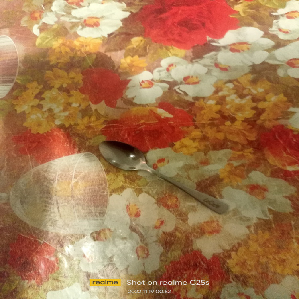

In [23]:
img = load_img(test_df.iloc[0]["image"], target_size=(299, 299))
img

In [25]:
x = np.array(img)
x.shape

(299, 299, 3)

In [26]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [27]:
X = preprocess_input(X)

In [28]:
X.shape

(1, 299, 299, 3)

In [29]:
pred = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [30]:
classes = list(train_ds.class_indices.keys())
classes

['cup', 'fork', 'glass', 'knife', 'plate', 'spoon']

In [31]:
dict(zip(classes, pred[0]))

{'cup': -3.9303498,
 'fork': 3.8485677,
 'glass': -5.036075,
 'knife': 0.8951325,
 'plate': -2.3622494,
 'spoon': 5.5949364}

In [40]:
result_label = sorted(dict(zip(classes, pred[0])).items(), key=lambda kv: (-kv[1], kv[0]))[0][0]
result_label


'spoon'

### Generating Results  X_test values

In [41]:
classes = list(train_ds.class_indices.keys())


def result_label(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = np.array(img)
    X = np.array([x])
    X = preprocess_input(X)
    pred = model.predict(X)
    result_label = sorted(dict(zip(classes, pred[0])).items(), key=lambda kv: (-kv[1], kv[0]))[0][0]
    
    return result_label

In [42]:
test_df['label'] = test_df['image'].map(result_label)

1/1 [==============================] - 0s 25ms/step


In [43]:
test_df

,Id,image,label
0,6534,./kitchenware-classification/images/6534.jpg,spoon
1,3504,./kitchenware-classification/images/3504.jpg,knife
2,1649,./kitchenware-classification/images/1649.jpg,fork
3,4815,./kitchenware-classification/images/4815.jpg,plate
4,1651,./kitchenware-classification/images/1651.jpg,fork
...,...,...,...
2357,6530,./kitchenware-classification/images/6530.jpg,plate
2358,6531,./kitchenware-classification/images/6531.jpg,plate
2359,3501,./kitchenware-classification/images/3501.jpg,glass
2360,6533,./kitchenware-classification/images/6533.jpg,plate


In [44]:
submission = test_df[["Id", "label"]]
submission.head()

,Id,label
0,6534,spoon
1,3504,knife
2,1649,fork
3,4815,plate
4,1651,fork


In [47]:
submission.shape

(2362, 2)

In [45]:
submission.to_csv("submission.csv", index=False)

In [46]:
!head -n 10 submission.csv

Id,label
6534,spoon
3504,knife
1649,fork
4815,plate
1651,fork
1652,spoon
6536,spoon
1654,fork
3508,knife
